
Install Dependencies


In [ ]:
import os
import json
import subprocess
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import pandas as pd

In [ ]:
!apt-get install -y asymptote

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  asymptote-doc dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-urw-base35 freeglut3 ghostscript gsfonts imagemagick
  imagemagick-6-common imagemagick-6.q16 info install-info
  libalgorithm-c3-perl libauthen-sasl-perl libb-hooks-endofscope-perl
  libb-hooks-op-check-perl libclass-c3-perl libclass-c3-xs-perl
  libclass-data-inheritable-perl libclass-method-modifiers-perl
  libclass-xsaccessor-perl libcommon-sense-perl libdata-optlist-perl
  libdevel-callchecker-perl libdevel-caller-perl
  libdevel-globaldestruction-perl libdevel-lexalias-perl
  libdevel-stacktrace-perl libdist-checkconflicts-perl libdjvulibre-text
  libdjvulibre21 libdynaloader-functions-perl libemail-date-format-perl
  libeval-closure-perl libexception-class-perl libfftw3-double3
  libfile-homedir-perl libfile-which-perl libgs9 libgs9-common

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data

In [ ]:
generated_data_path = "/content/drive/MyDrive/asymptote_model/eval/generated_predictions.jsonl"
dir_rendered = "/content/drive/MyDrive/asymptote_model/eval/rendered"
os.makedirs(dir_rendered, exist_ok=True)

log_path = "/content/drive/MyDrive/asymptote_model/eval/syntax_render_log.jsonl"

In [ ]:
# Load predictions
with open(generated_data_path, "r") as f:
    predictions = [json.loads(line) for line in f]

# Helpers Functions
def save_asy_code(code_str, out_path):
    with open(out_path, "w") as f:
        f.write(code_str)

def compile_asy(asy_path, out_img_path):
    try:
        subprocess.run(
            ["asy", "-f", "png", "-o", out_img_path, asy_path],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            timeout=10
        )
        return True, ""
    except subprocess.CalledProcessError as e:
        return False, e.stderr.decode()
    except subprocess.TimeoutExpired:
        return False, "Timeout expired"



Evaluation Loop

In [ ]:
results = []
for sample in tqdm(predictions, desc="Compiling and Rendering"):
    sample_id = sample.get("id", "")
    asy_code = sample["generated_code"]

    asy_path = os.path.join(dir_rendered, f"{sample_id}.asy")
    img_path = os.path.join(dir_rendered, f"{sample_id}.png")

    save_asy_code(asy_code, asy_path)
    success, error_msg = compile_asy(asy_path, img_path)

    results.append({
        "id": sample_id,
        "compiles": success,
        "error_msg": error_msg,
        "asy_path": asy_path,
        "img_path": img_path if success else None
    })


Compiling and Rendering: 100%|██████████| 260/260 [00:20<00:00, 12.78it/s]


Save Log

In [ ]:
with open(log_path, "w") as f:
    for r in results:
        json.dump(r, f)
        f.write("\n")

Display Summary

In [ ]:
df = pd.DataFrame(results)
total = len(df)
compiled = df["compiles"].sum()
print(f"\nSyntactic Evaluation Complete.")
print(f"Compiled: {compiled}/{total} ({compiled/total:.2%})")


Syntactic Evaluation Complete.
Compiled: 0/260 (0.00%)


Evaluation Metrics


1.   Exact Match
2.   Syntactic Similarity
3.   Visual Fidelity (Images failed to render)


In [ ]:
# Paths
generated_data_path = "/content/drive/MyDrive/asymptote_model/eval/generated_predictions.jsonl"
ground_truth_path = "/content/drive/MyDrive/asymptote_model/data/asymptote_dataset_final.jsonl"

# Load generated predictions
with open(generated_data_path, "r") as f:
    generated_samples = {sample["id"]: sample["generated_code"].strip() for sample in map(json.loads, f)}

# Load full ground truth dataset
with open(ground_truth_path, "r") as f:
    all_ground_truth = {sample["id"]: sample["asy_code"].strip() for sample in map(json.loads, f)}

# Match only samples present in the generated set
results = []
for sample_id, gen_code in tqdm(generated_samples.items(), desc="Evaluating similarities"):
    if sample_id in all_ground_truth:
        gt_code = all_ground_truth[sample_id]
        similarity = SequenceMatcher(None, gen_code, gt_code).ratio()
        exact = gen_code == gt_code
        results.append({
            "id": sample_id,
            "exact_match": exact,
            "similarity": round(similarity, 4)
        })

# Convert to DataFrame
df_similarity = pd.DataFrame(results).sort_values(by="similarity", ascending=True).reset_index(drop=True)

# Compute summary stats
avg_sim = df_similarity["similarity"].mean()
exact_pct = df_similarity["exact_match"].mean() * 100

avg_sim, exact_pct, len(df_similarity)

Evaluating similarities: 100%|██████████| 260/260 [00:00<00:00, 457.10it/s]


(np.float64(0.05293730769230769), np.float64(0.0), 260)

Visualize Syntactic Similarity

In [ ]:
display(df_similarity.head())

,id,exact_match,similarity
0,0145,False,0.0031
1,0564,False,0.0032
2,1188,False,0.0036
3,1495,False,0.0039
4,0843,False,0.0046


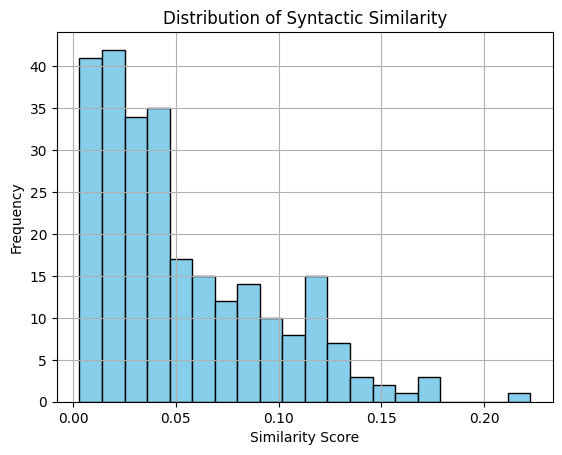

In [ ]:
import matplotlib.pyplot as plt

similarities = [r['similarity'] for r in results]
plt.hist(similarities, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Syntactic Similarity")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()